In [40]:
from utilities.my_plots import my_heatmap
from IPython.core.interactiveshell import InteractiveShell
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import (
    Normalize, LogNorm,
    LinearSegmentedColormap,
    TwoSlopeNorm
)
import math
from matplotlib.ticker import (
    LogFormatterMathtext,
    PercentFormatter
)


import sys
sys.path.insert(0, r"G:\My Drive\Data Science")

InteractiveShell.ast_node_interactivity = "all"

In [3]:
if os.path.exists('ndx.csv'):
    data = pd.read_csv('ndx.csv')
else:
    # Download NASDAQ 100 data
    ticker = "^NDX"
    nasdaq_100 = yf.Ticker(ticker)
    data = nasdaq_100.history(period="max")
    data = data.reset_index()
    data = data.rename(columns={'Date': 'date'})
    data['year'] = data.date.year
    data.to_csv('ndx.csv', index=False)

In [17]:
class LogTwoSlopeNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        LogNorm.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Create an empty masked array of the same shape as `value`
        result = np.ma.masked_array(np.zeros(value.shape), mask=False)

        # Find where the values are NaN or inf
        invalid = np.isnan(value) | np.isinf(value)

        # Mask those invalid entries
        result.mask |= invalid

        # Calculate log and normalization for the non-invalid and non-masked entries
        log_vcenter = np.log(self.vcenter)
        log_vmin = np.log(self.vmin)
        log_vmax = np.log(self.vmax)

        x, y = [log_vmin, log_vcenter, log_vmax], [0, 0.5, 1]
        result[~invalid] = np.interp(np.log(value[~invalid]), x, y)

        return result

    def inverse(self, value):
        log_vcenter = np.log(self.vcenter)
        log_vmin = np.log(self.vmin)
        log_vmax = np.log(self.vmax)

        x, y = [log_vmin, log_vcenter, log_vmax], [0, 0.5, 1]
        return np.exp(np.interp(value, y, x))

In [8]:
if os.path.exists('ndx_profit_loss.csv'):
    profit_loss = pd.read_csv('ndx_profit_loss.csv')
    with open('time_buy.pkl', 'rb') as file:
        time_buy = pickle.load(file)
    with open('time_sell.pkl', 'rb') as file:
        time_sell = pickle.load(file)
else:
    number_of_bussiness_days_per_interval = 10
    total_number_of_bussiness_days = len(data)

    number_of_intervals = \
        total_number_of_bussiness_days // \
        number_of_bussiness_days_per_interval

    profit_loss = np.full(
        fill_value=np.nan,
        shape=(number_of_intervals, number_of_intervals)
    )
    ratios = np.full(
        fill_value=np.nan,
        shape=(number_of_intervals, number_of_intervals)
    )
    time_buy = []
    time_sell = []

    for i in range(number_of_intervals):
        start_idx = i * number_of_bussiness_days_per_interval
        for j in range(i+1, number_of_intervals):
            end_idx = j * number_of_bussiness_days_per_interval
            price_sell = data['Close'].iloc[end_idx]
            price_buy = data['Close'].iloc[start_idx]
            profit_loss[j, i] = (price_sell - price_buy) / price_buy
            ratios[j, i] = price_sell / price_buy
        time_buy.append(data.date.iloc[start_idx])

    for j in range(1, 1+number_of_intervals):
        end_idx = j * number_of_bussiness_days_per_interval
        time_sell.append(data.date.iloc[end_idx])

    # Create a DataFrame with the profit information
    profit_loss = pd.DataFrame(profit_loss)
    ratios = pd.DataFrame(ratios)

    profit_loss = profit_loss.iloc[::-1, :].reset_index(drop=True)
    ratios = ratios.iloc[::-1, :].reset_index(drop=True)

    profit_loss.to_csv('ndx_profit_loss.csv', index=False)
    ratios.to_csv('ndx_ratios.csv', index=False)

    with open('time_buy.pkl', 'wb') as file:
        pickle.dump(time_buy, file)
    with open('time_sell.pkl', 'wb') as file:
        pickle.dump(time_sell, file)

In [11]:
def get_first_bussiness_days(time_list):
    time_series = pd.Series(time_list)

    first_business_day_per_year = (
        time_series
        .groupby(pd.Series(time_buy).str[:4])
        .first()
        .iloc[1:]
    )

    indices = time_series[time_series.isin(
        first_business_day_per_year)].index
    return time_series[indices]


x_ticks_series = get_first_bussiness_days(time_buy)
y_ticks_series = get_first_bussiness_days(time_sell)

x_ticks_series = x_ticks_series.iloc[::2]
y_ticks_series = y_ticks_series.iloc[::2]

# since the ylim of this plot starts from a large integer
# and ends in 0, we must transform the indices accordingly
y_ticks_series.index = len(time_sell) - y_ticks_series.index

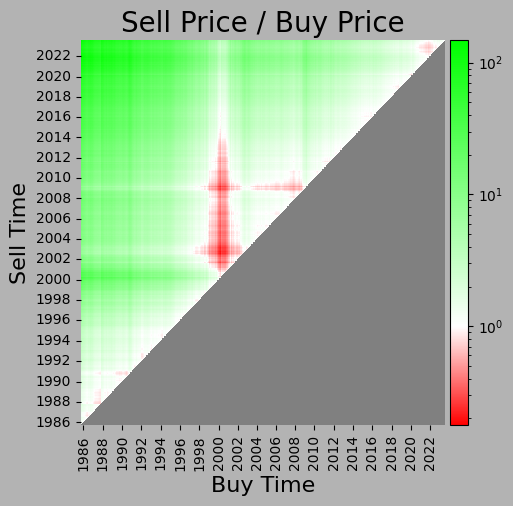

In [18]:
base = 10

# Define the center of the colormap
vcenter = 1

vmin = ratios.min().min()
vmax = ratios.max().max()

norm = LogTwoSlopeNorm(
    vmin=vmin,
    vcenter=vcenter,
    vmax=vmax,
)

colors = [
    (1, 0, 0),
    (1, 1, 1),
    (0, 1, 0)
]
cmap_name = 'custom1'
cmap = LinearSegmentedColormap.from_list(
    cmap_name, colors, N=256)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 5))  # You can set the size as needed

ax = sns.heatmap(
    ratios,
    mask=ratios.isna(),
    cmap=cmap,
    norm=norm,
    cbar=False,
    ax=ax
)

# Manually creating the colorbar

divider = make_axes_locatable(plt.gca())

cax = divider.append_axes("right", size="5%", pad=0.05)

# Set the scale of the colorbar to be logarithmic
cbar = plt.colorbar(ax.get_children()[0], cax=cax)

# Define the ticks
log_min = np.log10(vmin)
log_max = np.log10(vmax)
ratio = (log_max - 1) / (1 - log_min)

log_step = 1
number_of_decimals = 0
scale = 10**number_of_decimals

log_ticks = np.arange(
    np.ceil(scale * log_min) / scale,
    np.floor(scale * log_max) / scale + log_step,
    log_step
)
cbar_ticks = 10**log_ticks

# Set the ticks
cbar.set_ticks(cbar_ticks)

# Format the ticks as 10^x
tolerance = 1e-10
cbar_labels = [
    f'$10^0$' if np.abs(tick) < tolerance else f'$10^{{{int(tick)}}}$'
    for tick in np.round(log_ticks, 2)
]
cbar.ax.set_yticklabels(cbar_labels)

# Set background colors
fig_gray_shade = 0.7
ax_gray_shade = 0.5


ax.set_facecolor(
    [
        ax_gray_shade,
        ax_gray_shade,
        ax_gray_shade,
    ]
)

plt.gcf().set_facecolor(
    [
        fig_gray_shade,
        fig_gray_shade,
        fig_gray_shade,
    ]
)

# Set the new x-axis tick positions and labels
ax.set_xticks(x_ticks_series.index)
ax.set_xticklabels(x_ticks_series.str[:4])

# Set the new y-axis tick positions and labels
ax.set_yticks(y_ticks_series.index)
ax.set_yticklabels(y_ticks_series.str[:4])

ax.set_title(
    'Sell Price / Buy Price',
    fontsize=20
)


ax.set_aspect('auto')

ax.set_ylabel('Sell Time', fontsize=16)
ax.set_xlabel('Buy Time', fontsize=16)

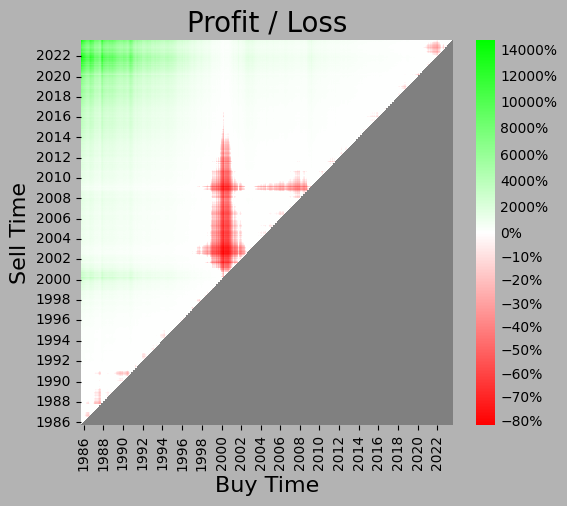

In [47]:
base = 10

# Define the center of the colormap
vcenter = 0

vmin = profit_loss.min().min()
vmax = profit_loss.max().max()

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)


colors = [
    (1, 0, 0),
    (1, 1, 1),
    (0, 1, 0)
]

cmap_name = 'custom1'
cmap = LinearSegmentedColormap.from_list(
    cmap_name, colors, N=256)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 5))  # You can set the size as needed

sns_plot = sns.heatmap(
    profit_loss,
    mask=profit_loss.isna(),
    cmap=cmap,
    norm=norm,
    # cbar=False,
    ax=ax
)

# Access the color bar
cbar = sns_plot.collections[0].colorbar

# Manually specify the positions and labels of the ticks
negative_ticks = np.arange(-0.8, 0, 0.1)
positive_ticks = np.arange(0, 150, 20)
negative_tick_labels = np.array([np.round(tick, 1) for tick in negative_ticks])
positive_tick_labels = np.array([int(tick) for tick in positive_ticks])

tick_positions = np.hstack((
    negative_ticks,
    positive_ticks,
))
tick_labels = np.hstack((
    negative_tick_labels,
    positive_tick_labels,
))

# Set tick positions and labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

# Set the tick length to zero
cbar.ax.tick_params(length=0)

cbar.ax.yaxis.set_major_formatter(PercentFormatter(1))


# Set background colors
fig_gray_shade = 0.7
ax_gray_shade = 0.5


ax.set_facecolor(
    [
        ax_gray_shade,
        ax_gray_shade,
        ax_gray_shade,
    ]
)

plt.gcf().set_facecolor(
    [
        fig_gray_shade,
        fig_gray_shade,
        fig_gray_shade,
    ]
)

# Set the new x-axis tick positions and labels
ax.set_xticks(x_ticks_series.index)
ax.set_xticklabels(x_ticks_series.str[:4])

# Set the new y-axis tick positions and labels
ax.set_yticks(y_ticks_series.index)
ax.set_yticklabels(y_ticks_series.str[:4])

ax.set_title(
    'Profit / Loss',
    fontsize=20
)


ax.set_aspect('auto')

ax.set_ylabel('Sell Time', fontsize=16)
ax.set_xlabel('Buy Time', fontsize=16)


path = 'images//ndx_profit_loss.png'
plt.savefig(path, dpi=100, bbox_inches="tight", pad_inches=0.25)

In [66]:
pd.cut(
    profit_loss.stack().reset_index(drop=True),
    bins=[-np.infty, -10**-10, 10**-10, np.infty]
).value_counts(normalize=True)

(1e-10, inf]       0.930402
(-inf, -1e-10]     0.069596
(-1e-10, 1e-10]    0.000002
Name: proportion, dtype: float64